# Find the central star of CTIO Data in May 2017
==================================================================================================

- author : Jérémy Neveu
- date   : May 31st 2017


The goal of this notebook is to cut a part of the image around the main central star.
The rest of the image is useless.
This region around the central star is necessary to perform the rotation of the images without
any biases due to other stars.


In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
print theNotebook

FindCentralStar


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [6]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.2.0


In [7]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [8]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [9]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [10]:
%load_ext Cython

In [11]:
from IPython.display import Image, display

In [12]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [13]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [14]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)¶

In [15]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [16]:
ensure_dir(dir_top_images) # create that directory

### Input directory

In [17]:
!ls ../OverScanRemove/trim_images

trim_20170531_001.fits trim_20170531_097.fits trim_20170531_188.fits
trim_20170531_002.fits trim_20170531_098.fits trim_20170531_189.fits
trim_20170531_003.fits trim_20170531_099.fits trim_20170531_190.fits
trim_20170531_004.fits trim_20170531_100.fits trim_20170531_191.fits
trim_20170531_005.fits trim_20170531_101.fits trim_20170531_192.fits
trim_20170531_006.fits trim_20170531_102.fits trim_20170531_193.fits
trim_20170531_007.fits trim_20170531_103.fits trim_20170531_194.fits
trim_20170531_008.fits trim_20170531_104.fits trim_20170531_195.fits
trim_20170531_009.fits trim_20170531_105.fits trim_20170531_196.fits
trim_20170531_010.fits trim_20170531_106.fits trim_20170531_197.fits
trim_20170531_011.fits trim_20170531_107.fits trim_20170531_198.fits
trim_20170531_012.fits trim_20170531_108.fits trim_20170531_199.fits
trim_20170531_013.fits trim_20170531_109.fits trim_20170531_200.fits
trim_20170531_014.fits trim_20170531_110.fits trim_20170531_201.fits
trim_20170531_015.fits trim_201705

In [18]:
inputdir="../OverScanRemove/trim_images"
MIN_IMGNUMBER=116
MAX_IMGNUMBER=140
object_name='HD185975'
SelectTagRe='^trim_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170531_[0-9]+.fits$'
NBIMGPERLROW=4

### Output directory fot fits images

In [19]:
outputdir="./cut_fitsimages"

In [20]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [21]:
input_filelist=os.listdir(inputdir) 

In [22]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [23]:
print input_filelist[:5]

['trim_20170531_001.fits' 'trim_20170531_002.fits' 'trim_20170531_003.fits'
 'trim_20170531_004.fits' 'trim_20170531_005.fits']


In [24]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list
dirlist_all = [inputdir]

In [25]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    
    - we select the files which are of interest.
    - In particular select the number range
    
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image   (if necessary)    
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search(SearchTagRe,filename):  #example of filename filter
                    str_index=re.findall(SelectTagRe,filename)
                    count=count+1
                    index=int(str_index[0])
                    if index >= MIN_IMGNUMBER and index <= MAX_IMGNUMBER: 
                        indexes_files.append(index)         
                        shortfilename=dir_leaf+'/'+filename
                        filelist_fitsimages.append(shortfilename)
                    
    return 

In [26]:
MakeFileList()   # Make the list

In [27]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [28]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [29]:
sorted_numbers=indexes_files[sorted_indexes]

In [30]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

## Build full filename
----------------------------

In [31]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [32]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

## Acces to data of  images
----------------------------------

In [33]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt = []

In [34]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_filt = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        filters = header['FILTERS']
    
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_filt

In [35]:
all_dates,all_airmass,all_images,all_titles,all_header,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

In [36]:
#all_filt

## Show images
-----------------------

In [37]:
len(all_images)

25

In [38]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    #global all_images
    #global all_titles
    #global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,5*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        #im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',norm=LogNorm(vmin=0.1, vmax=10))
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=0, vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        axarr[iy,ix].text(1000.,1700,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
    title='Raw images of {}'.format(object_name)
    plt.suptitle(title,size=16)    
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)   

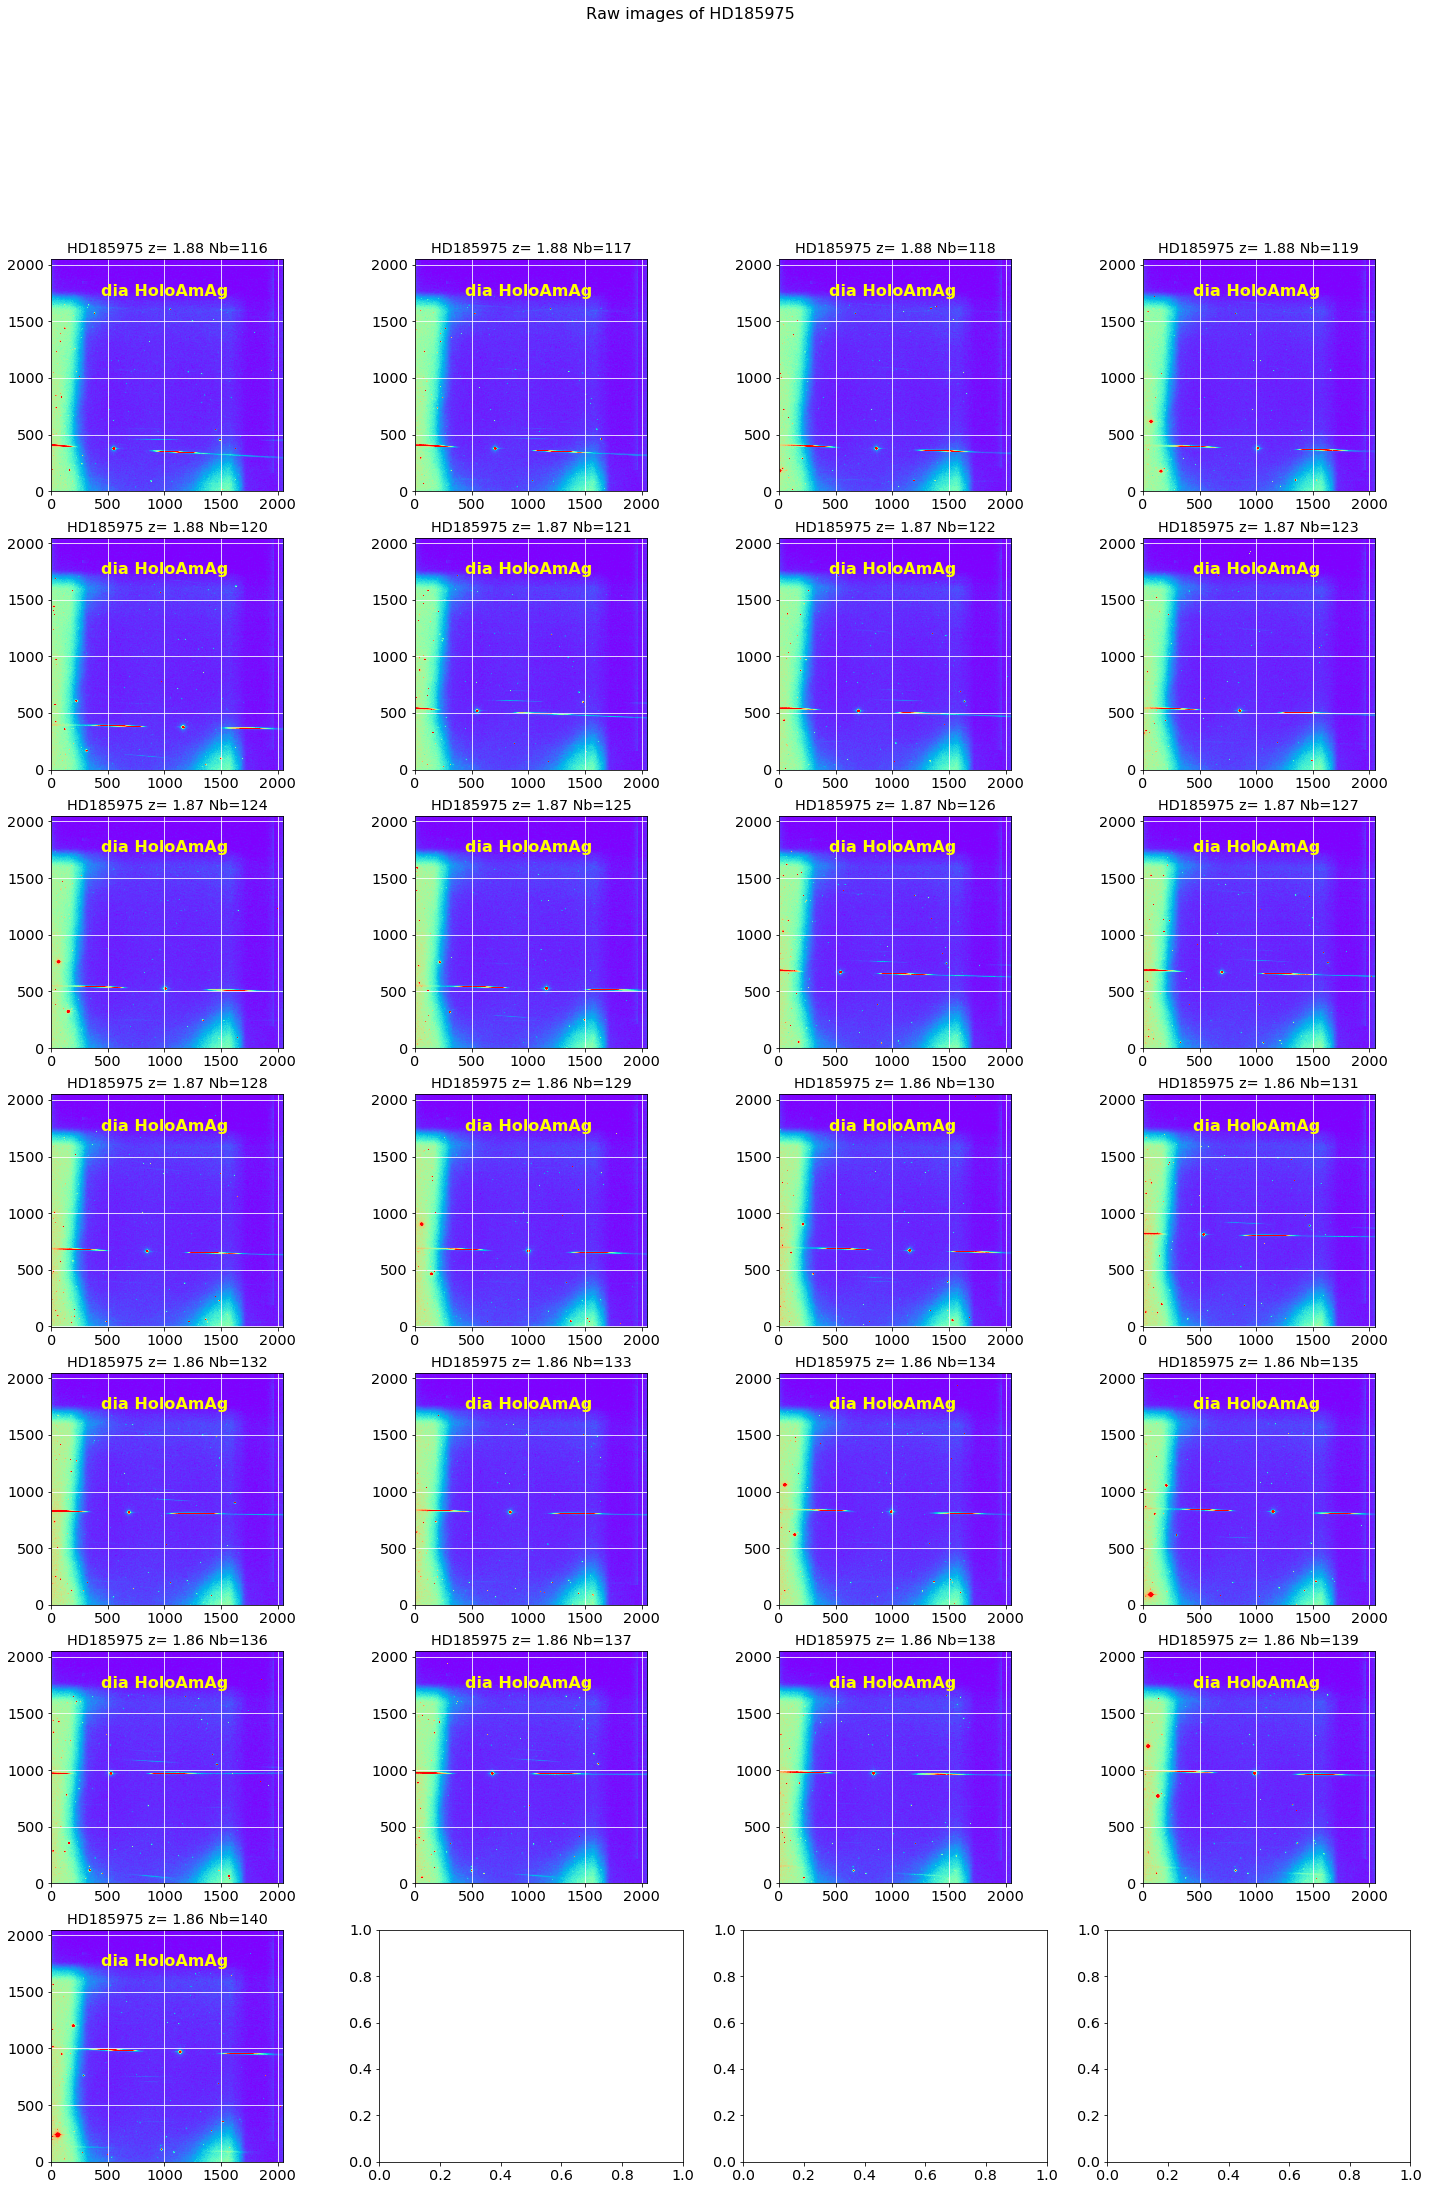

In [39]:
ShowRawImages()

### Find the star locations
----------------------------

In [40]:
%%cython
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind

def ComputeStatImages(all_images):
    """
    ComputeStatImages: 
    ==============
    """
    
    img_mean=[]
    img_median=[]
    img_std=[]
    img_sources=[]
    img_=[]
    index=0
    for image in all_images:
        mean, median, std = sigma_clipped_stats(image, sigma=10.0, iters=5)    
        print '----------------------------------------------------------------'
        print index,' mean, median, std = ',mean, median, std
        img_mean.append(mean)
        img_median.append(median)
        img_std.append(std)
        sources = daofind(image - median, fwhm=22, threshold=300*std) # (JN) valeurs optimisées pour cette étude
        print sources
        img_sources.append(sources)    
        index+=1
    return img_mean,img_median,img_std,img_sources

In [41]:
img_mean,img_median,img_std,img_sources=ComputeStatImages(all_images)

----------------------------------------------------------------
0  mean, median, std =  84.2916792389 45.0 118.457741645


        Use DAOStarFinder instead. [astropy.utils.decorators]


 id   xcentroid     ycentroid   ...   peak       flux          mag      
--- ------------- ------------- ... ------- ------------- --------------
  1 551.412436572 372.829838122 ... 60682.0 9.04850844254 -2.39144248985
----------------------------------------------------------------
1  mean, median, std =  83.8195222288 44.0 117.855267734
 id   xcentroid     ycentroid   ...   peak       flux          mag      
--- ------------- ------------- ... ------- ------------- --------------
  1 703.640638461 372.997367774 ... 60685.0 8.66606417283 -2.34455475173
----------------------------------------------------------------
2  mean, median, std =  83.1151484657 44.0 116.878525942
 id   xcentroid     ycentroid   ...   peak       flux          mag      
--- ------------- ------------- ... ------- ------------- --------------
  1 855.878534596 374.105128905 ... 60683.0 8.85546740159 -2.36802872171
----------------------------------------------------------------
3  mean, median, std =  82.4274880

### Central star positions

In [42]:
flux_cuts = [6,11]
x_star = []
y_star = []
for s in img_sources:
    for ss in s :
        if ss["flux"] < flux_cuts[1] and ss["flux"]>flux_cuts[0]:
            x_star.append(ss["xcentroid"])
            y_star.append(ss["ycentroid"])

In [43]:
positions_central = np.array([y_star, x_star]).T
print positions_central

[[  372.82983812   551.41243657]
 [  372.99736777   703.64063846]
 [  374.10512891   855.8785346 ]
 [  375.77655125  1008.11270178]
 [  377.34568638  1160.80516707]
 [  519.64713658   545.76762314]
 [  519.13826111   697.79276677]
 [  520.23507064   850.36665476]
 [  522.68522348  1002.61031287]
 [  524.42552058  1154.96885432]
 [  666.2736932    540.09125832]
 [  666.3732723    692.11595032]
 [  666.05154191   844.57584336]
 [  668.56221003   995.71757872]
 [  672.98013208  1147.86053302]
 [  813.55365672   532.52991473]
 [  814.84125383   684.26299344]
 [  816.2647414    836.24522106]
 [  819.16616404   988.43234122]
 [  820.39929492  1142.55056491]
 [  963.76760211   525.91716871]
 [  963.25356551   678.03198771]
 [  964.46537508   830.14156257]
 [  965.73835588   982.13360069]
 [  967.71202586  1134.65735634]]


In [57]:
# Default position
x0 = x_star[len(img_sources)/2]
y0 = y_star[len(img_sources)/2]

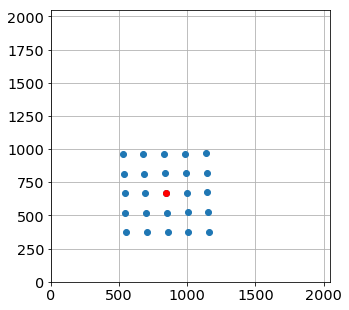

In [58]:
img_size=all_images[0].shape
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.plot(x0,y0,'ro')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

### Cut the image

In [59]:
DeltaY=200
DeltaX=600

In [60]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
import os

def ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images):
    """
    ShowCenterImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1
    
    #global dir_top_images
    
    croped_images = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,3*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        y0=int(positions_central[index][0])
        x0=int(positions_central[index][1])
       
        #image_cut=all_images[index][y0-200:y0+200,x0-200,y0+200]
        theimage=all_images[index]
        #image_cut=theimage[y0-DeltaY:y0+DeltaY,x0-DeltaX:x0+DeltaX]
        image_cut=np.copy(theimage[y0-DeltaY:y0+DeltaY,:])
        croped_images.append(image_cut)
        #aperture=CircularAperture([positions_central[index]], r=100.)
        im=axarr[iy,ix].imshow(image_cut,cmap='rainbow',vmin=0,vmax=1000,origin='lower',interpolation='None')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        #aperture.plot(color='red', lw=5.)
    title='Cut Images of {}'.format(object_name)
    plt.suptitle(title,size=16) 
    
    figfilename=os.path.join(dir_top_images,'cut_images.pdf')
    plt.savefig(figfilename)   
    
    
    return croped_images

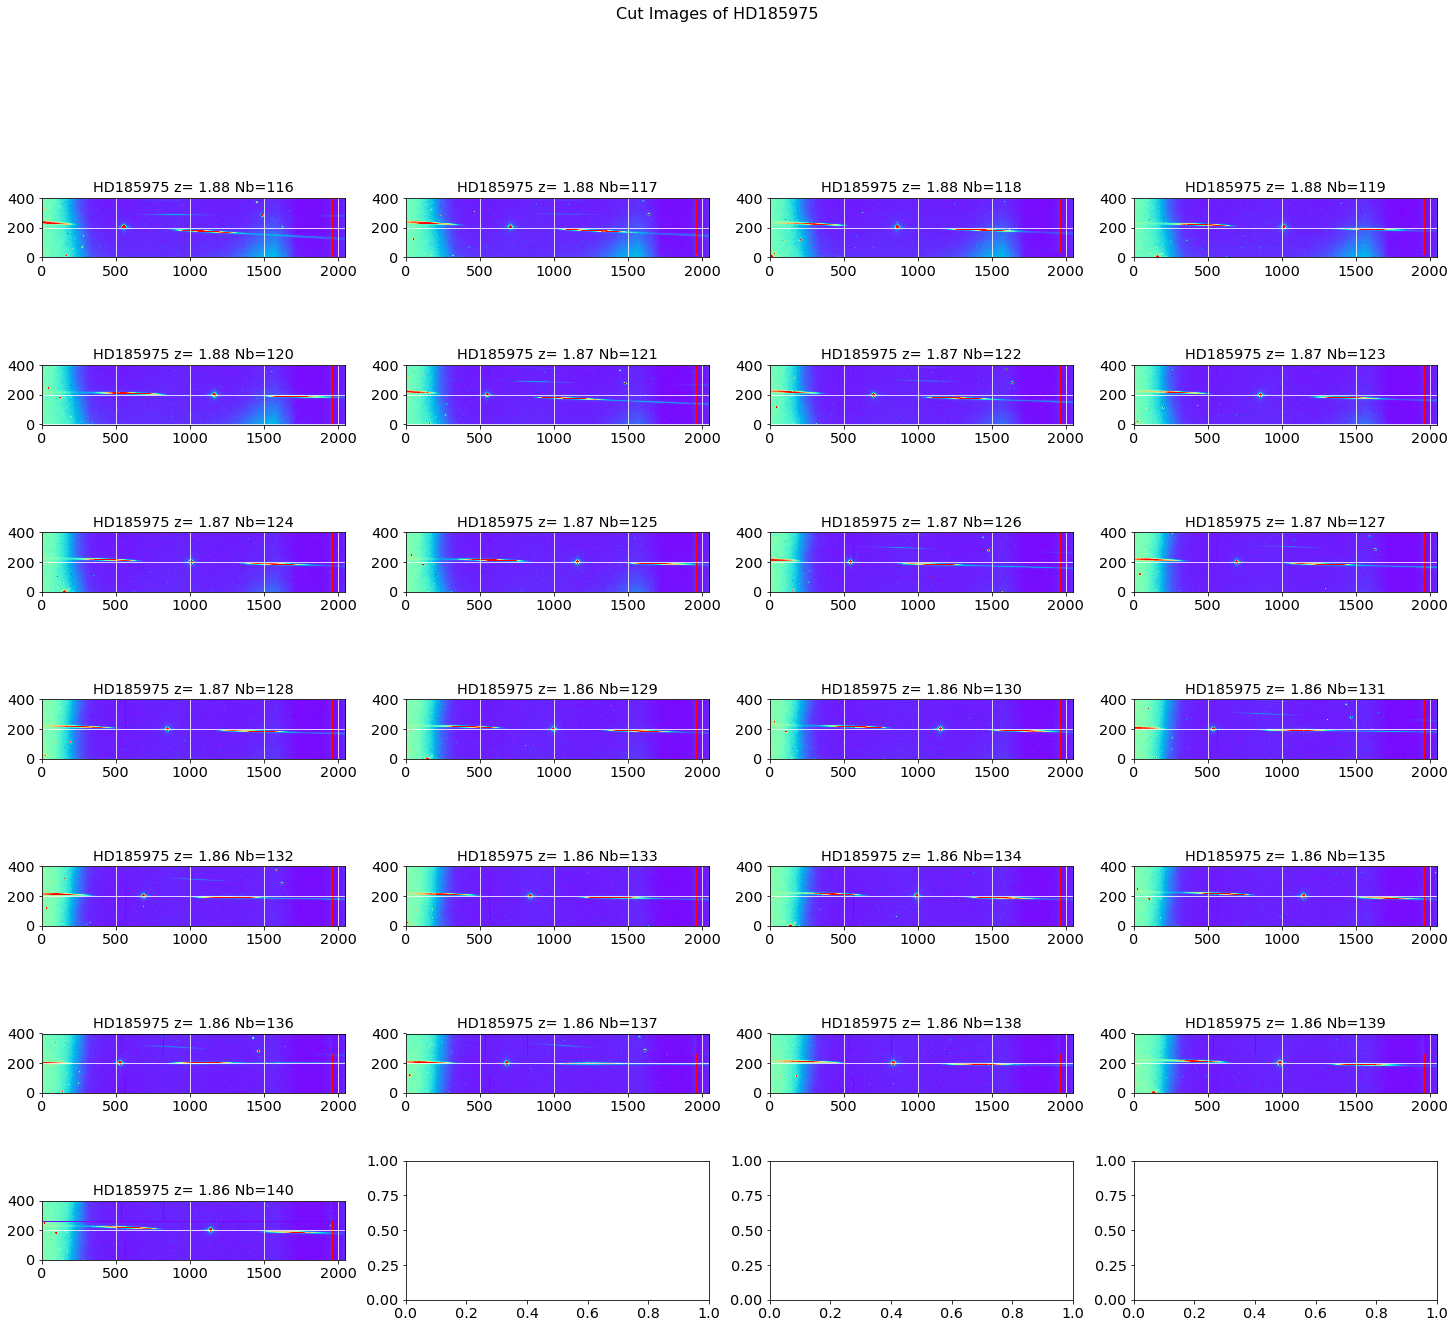

In [61]:
images_cut=ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images)

#### Example of cut image
-------------------------

In [62]:
index=0
data=np.copy(images_cut[index])
w=20
ws=80
data[:,DeltaX-ws:DeltaX+ws]=0

In [63]:
yprofile=np.sum(data,axis=1)
xprofile=np.sum(data,axis=0)

In [64]:
y_center=np.where(yprofile==yprofile.max())[0][0]
print y_center

172


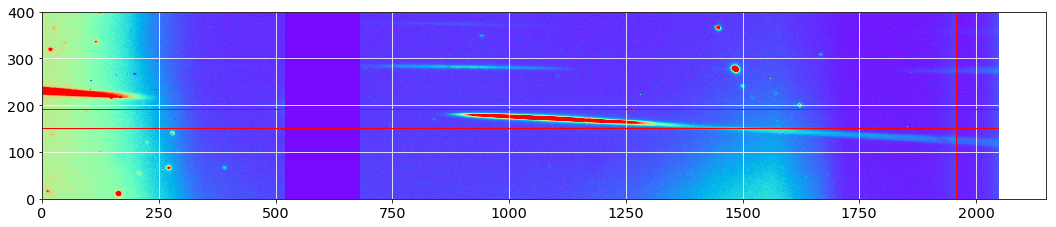

In [65]:
plt.figure(figsize=(18,18))
y0=int(positions_central[index][0])
x0=int(positions_central[index][1])
plt.imshow(data,vmin=-10,vmax=800,origin='lower',cmap='rainbow',interpolation='None')
plt.plot([0,data.shape[1]],[y_center-w,y_center-w],'r-',lw=1)
plt.plot([0,data.shape[1]],[y_center+w,y_center+w],'r-',lw=1)
plt.grid(color='white', ls='solid')
plt.show()
figfilename=os.path.join(dir_top_images,'cutimages_sample.pdf')
plt.savefig(figfilename)   

### prepare outputfilename

In [66]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    
    short_infilename=file.split("/")[3]
    print short_infilename
    short_partfilename=re.findall('^trim_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

trim_20170531_116.fits
trim_20170531_117.fits
trim_20170531_118.fits
trim_20170531_119.fits
trim_20170531_120.fits
trim_20170531_121.fits
trim_20170531_122.fits
trim_20170531_123.fits
trim_20170531_124.fits
trim_20170531_125.fits
trim_20170531_126.fits
trim_20170531_127.fits
trim_20170531_128.fits
trim_20170531_129.fits
trim_20170531_130.fits
trim_20170531_131.fits
trim_20170531_132.fits
trim_20170531_133.fits
trim_20170531_134.fits
trim_20170531_135.fits
trim_20170531_136.fits
trim_20170531_137.fits
trim_20170531_138.fits
trim_20170531_139.fits
trim_20170531_140.fits


### Save outputfilename

In [67]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)
textfilename=os.path.join(outputdir,'star_centroids.txt')
print textfilename
np.savetxt(textfilename,positions_central,header="y_star x_star",fmt='%d')

./cut_fitsimages/star_centroids.txt


In [68]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 jneveu  staff  6566400  3 jui 03:21 cut_fitsimages/cutimg_20170531_116.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 03:21 cut_fitsimages/cutimg_20170531_117.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 03:21 cut_fitsimages/cutimg_20170531_118.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 03:21 cut_fitsimages/cutimg_20170531_119.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 03:21 cut_fitsimages/cutimg_20170531_120.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 03:21 cut_fitsimages/cutimg_20170531_121.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 03:21 cut_fitsimages/cutimg_20170531_122.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 03:21 cut_fitsimages/cutimg_20170531_123.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 03:21 cut_fitsimages/cutimg_20170531_124.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 03:21 cut_fitsimages/cutimg_20170531_125.fits
-rw-r--r--  1 jneveu  staff  6566400  3 jui 03:21 cut_fitsimages/cutimg_20170531_126.fits
-rw-r--r--